In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
def make_train_tests(DIR="../input/"):
    train=pd.read_csv(DIR+"/stage2_final_train.csv",index_col=0)
    test=pd.read_csv(DIR+"/stage2_final_test.csv",index_col=0)
    labels=train['Class']
    train=train.drop("Class",axis=1)
    assert (train.columns==test.columns).all()
    return (train.values.astype(np.float32),labels.values-1),test.values.astype(np.float32)

In [3]:
(train,labels),test=make_train_tests()
train.shape,labels.shape,test.shape

((3689, 6500), (3689,), (986, 6500))

In [4]:
train.nbytes/1024*2.,test.nbytes/1024*2.

(187332.0, 50070.0)

In [5]:
pd.Series(labels).value_counts()

6    1054
3     751
0     662
1     498
5     297
4     267
2      96
8      43
7      21
dtype: int64

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold
from sklearn.multiclass import OneVsRestClassifier
import lightgbm as lgb

In [7]:
lgb.__version__

'2.0.1'

In [8]:
def shuffle_XY(X,y):
    idx=np.random.permutation(range(len(y)))
    return X[idx],y[idx]
def shuffle_XY2(X,y):
    idx=np.random.choice(range(len(y)),replace=True,size=len(y))
    return X[idx],y[idx]

In [9]:
def make_model(i,trainx,trainy,colsample_bytree=1,num_leaves=31,subsample=1,
                                learning_rate=0.03,max_bin=127,min_gain_to_split=0,
                               lambda_l2=0,min_data_in_bin=5 ):
        models=[]
        X,y=shuffle_XY(trainx,trainy)
        kf = KFold(n_splits=5)
        scores=[]
        for train, test in kf.split(X):
            X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
            d_train = lgb.Dataset(X_train, label=y_train)
            d_valid = lgb.Dataset(X_test, label=y_test)
            params = {
                'task': 'train',
                'boosting_type': 'gbdt',
                'objective': 'multiclass',
                'num_leaves':num_leaves,
                'num_class':9,
                'metric': {'multi_logloss'},
                'learning_rate': learning_rate,
                'feature_fraction': colsample_bytree,
                'bagging_fraction': subsample,
                'max_bin': max_bin,
                'bagging_freq': 5,
                'verbose': 0,
                'metric_freq': 50,
                'min_gain_to_split':min_gain_to_split,
                'lambda_l2':lambda_l2,
                'min_data_in_bin':min_data_in_bin
            }
            print str(params)
            gbm = lgb.train(params,
                            d_train,
                            num_boost_round=5000,
                            valid_sets=d_valid,
                            early_stopping_rounds=50)

            models.append(gbm)
            pred=gbm.predict(X_test,num_iteration=gbm.best_iteration)
            scores.append(log_loss(y_test,pred,labels=range(9)))
            print log_loss(y_train,gbm.predict(X_train,num_iteration=gbm.best_iteration),labels=range(9)), scores[-1]
        print scores
        print i, "mean loss", np.mean(scores),np.std(scores)
        #return models
        return np.mean(scores),np.std(scores),models

In [10]:
param={'num_leaves': 15, 'colsample_bytree': 0.7, 'min_gain_to_split': 1, 'learning_rate': 0.01, 'lambda_l2': 0.5, 'subsample': 0.8, 'max_bin': 31, 'min_data_in_bin': 8}

In [11]:
def run_once(param,train,labels,test):
    colsample_bytree=param["colsample_bytree"]
    num_leaves=param["num_leaves"]
    subsample=param["subsample"]
    learning_rate=param["learning_rate"]
    max_bin=param["max_bin"]
    min_gain_to_split=param["min_gain_to_split"]
    lambda_l2=param["lambda_l2"]
    min_data_in_bin=param["min_data_in_bin"]
    
    scores=[]
    print param
    if 1:
        s,_,models=make_model(-1,train,labels,
                       colsample_bytree=colsample_bytree,
                       subsample=subsample,
                        learning_rate=learning_rate,
                       num_leaves=num_leaves,
                       max_bin=max_bin,
                       min_gain_to_split=min_gain_to_split,
                       lambda_l2=lambda_l2,
                       min_data_in_bin=min_data_in_bin
                      )
        print 'score:', s
        pred=np.mean([m.predict(test) for m in models],axis=0)

        return s,pred

In [12]:
#a=run_once(param,train,labels,test)

In [13]:
import findspark
findspark.init()

In [14]:
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql import SparkSession
conf = SparkConf()
conf.set('spark.executor.cores',1)
conf.set('spark.executor.instances',1) 
conf.set('spark.speculation','true') 
conf.set('spark.driver.memory','40G') 
conf.set('spark.executor.memory','45G') 

#conf.set('spark.cores.max',15)     
conf.setAppName("spark")
conf.setMaster("spark://192.168.0.11:7077")
#conf.setMaster("local")

In [15]:
spark = SparkSession.builder.config(conf=conf).getOrCreate()
sc=spark.sparkContext

In [16]:
from time import sleep

In [17]:
data=sc.broadcast((train,labels,test))
sleep(20)

In [18]:
N=500
a=sc.parallelize(range(N),N)
sleep(20)
a.getNumPartitions()

500

In [19]:
results=a.map(lambda u: run_once(param,data.value[0],data.value[1],data.value[2])).collect()

In [20]:
import cPickle as pickle

In [21]:
pickle.dump((param,results), open('lgb_predict_2.pkl','wb'))

In [22]:
len(results)

500

In [23]:
sc.stop()

In [24]:
files=["lgb_predict_1.pkl", 'lgb_predict_2.pkl']

In [25]:
pickled= reduce(lambda u,v: u+v, [pickle.load(open(fname))[1] for fname in files])

In [26]:
len(pickled)

595

In [28]:
plt.hist([u[0] for u in pickled],bins=50);
np.mean([u[0] for u in pickled]),np.std([u[0] for u in pickled])

(0.7217145045518133, 0.0045521755443951126)

In [29]:
u[1][0]

array([ 0.02211637,  0.00704279,  0.00411224,  0.90031259,  0.01650626,
        0.03791669,  0.00617743,  0.00295689,  0.00285873])

(0.90956149830232247, 0.0051035752349863264)

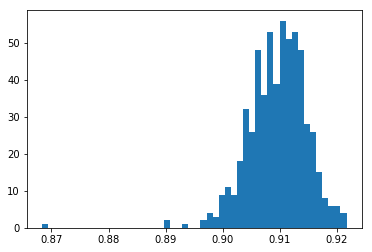

In [30]:
plt.hist([u[1][0][3] for u in pickled],bins=50);
np.mean([u[1][0][3] for u in pickled]),np.std([u[1][0][3] for u in pickled])

(0.02197127262211708, 0.0015257659042379344)

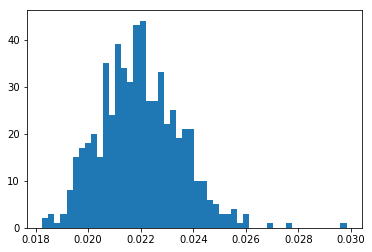

In [31]:
plt.hist([u[1][0][0] for u in pickled],bins=50);
np.mean([u[1][0][0] for u in pickled]),np.std([u[1][0][0] for u in pickled])

In [32]:
np.log(0.018),np.log(0.025)

(-4.0173835210859723, -3.6888794541139363)

In [33]:
np.log(0.9),np.log(0.92)

(-0.10536051565782628, -0.083381608939051013)

In [35]:
len(pickled)

595

In [38]:
mean_preds=np.mean([u[1] for u in pickled],0)

In [39]:
mean_preds.shape

(986, 9)

In [57]:
mean_preds.sum(1).mean()

1.0

In [42]:
test=pd.read_csv("../input/stage2_final_test.csv",index_col=0)

In [48]:
sample_sub=pd.read_csv("../input/stage2_sample_submission.csv",index_col=0)

In [58]:
submission=pd.DataFrame(mean_preds,index=test.index)
submission.columns=sample_sub.columns

In [59]:
submission

class1    class2    class3    class4    class5    class6    class7  \
ID                                                                          
1    0.021971  0.006572  0.004167  0.909561  0.013755  0.031789  0.006228   
2    0.981452  0.003270  0.001034  0.003444  0.001032  0.004496  0.002639   
3    0.026154  0.115012  0.023620  0.058562  0.040241  0.056395  0.658376   
4    0.062628  0.230529  0.006631  0.141013  0.012119  0.105357  0.429254   
5    0.005213  0.197073  0.005400  0.008422  0.008373  0.005473  0.765132   
6    0.055430  0.028505  0.012147  0.167847  0.031982  0.640888  0.045373   
7    0.016142  0.293602  0.010032  0.022221  0.019810  0.006276  0.614012   
8    0.229598  0.104050  0.011407  0.348853  0.030402  0.108857  0.154864   
9    0.201945  0.018695  0.011286  0.709066  0.015087  0.014794  0.022116   
10   0.004198  0.005922  0.192268  0.010762  0.043109  0.003717  0.735380   
11   0.033320  0.145305  0.008011  0.053566  0.104248  0.007317  0.638010   
12   0.002625  0.915402  0.002728  0.002886  0.003008  0.002232  0.067393   
13   0.936985  0.001897  0.004784  0.005401  0.042899  0.003069  0.001915   
14   0.002640  0.035526  0.005810  0.002782  0.004528  0.002097  0.944084   
15   0.040298  0.385932  0.013910  0.061453  0.041556  0.165635  0.271302   
16   0.810932  0.099857  0.005401  0.038579  0.010096  0.005919  0.011012   
17   0.127771  0.253045  0.005967  0.146865  0.022120  0.094290  0.334608   
18   0.056244  0.208393  0.010963  0.102938  0.020185  0.030328  0.559745   
19   0.033156  0.077100  0.009046  0.035754  0.035843  0.009221  0.788193   
20   0.096053  0.267533  0.011069  0.129276  0.022014  0.176926  0.282686   
21   0.004618  0.065842  0.003244  0.003798  0.004500  0.003333  0.911269   
22   0.004956  0.010370  0.004248  0.936156  0.011077  0.003997  0.004404   
23   0.631099  0.040502  0.015024  0.119342  0.047566  0.054916  0.068146   
24   0.003077  0.302279  0.003184  0.004205  0.003027  0.004841  0.673829   
25   0.183849  0.023125  0.009052  0.604079  0.012709  0.010584  0.144080   
26   0.004053  0.003853  0.004825  0.003546  0.006762  0.005423  0.967940   
27   0.046512  0.267288  0.004705  0.301971  0.007734  0.025782  0.336971   
28   0.034085  0.402632  0.008861  0.050523  0.017875  0.008320  0.462888   
29   0.008825  0.292988  0.009730  0.619455  0.015892  0.011305  0.035480   
30   0.088700  0.494795  0.006979  0.084826  0.023174  0.078655  0.211464   
..        ...       ...       ...       ...       ...       ...       ...   
957  0.004779  0.002469  0.007654  0.970155  0.005295  0.002750  0.004014   
958  0.009282  0.245022  0.010551  0.009004  0.032438  0.004994  0.680882   
959  0.959293  0.004630  0.004775  0.008882  0.007900  0.004646  0.004859   
960  0.385801  0.017543  0.007352  0.247157  0.022113  0.038844  0.262156   
961  0.110115  0.115184  0.007394  0.223793  0.021788  0.028699  0.484761   
962  0.001843  0.017495  0.002551  0.002208  0.002208  0.001400  0.969865   
963  0.930847  0.003735  0.001213  0.046152  0.001435  0.004689  0.007438   
964  0.166750  0.283354  0.066709  0.064316  0.100260  0.061586  0.156569   
965  0.026316  0.877814  0.004210  0.018974  0.025241  0.025436  0.016521   
966  0.044312  0.389667  0.010349  0.034171  0.033629  0.119268  0.348234   
967  0.274028  0.002029  0.002831  0.706987  0.005006  0.002553  0.003337   
968  0.010922  0.611650  0.006881  0.006330  0.011792  0.005263  0.337497   
969  0.625686  0.009286  0.006204  0.313135  0.015365  0.008346  0.009862   
970  0.185702  0.247831  0.026968  0.110447  0.059481  0.031461  0.298273   
971  0.778807  0.154136  0.004018  0.028405  0.007447  0.004803  0.009530   
972  0.535571  0.041349  0.005470  0.320226  0.010726  0.036772  0.042915   
973  0.790077  0.120837  0.006709  0.028465  0.017714  0.006016  0.014658   
974  0.011873  0.115315  0.010917  0.035014  0.017234  0.007395  0.793492   
975  0.042017  0.232727  0.007418  0.192278  0.016254  0.042763  0.454922   
976

In [61]:
submission.sum(1).mean()

1.0

In [62]:
submission.to_csv("../input/sub_lgb.csv")